In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
import matplotlib.patches as mpatches

## Adaptative Learning Agent

In [2]:
N_ROWS = 4
N_COLS = 5
GRID_WORLD = np.zeros((N_ROWS, N_COLS))

TARGET_POS1 = (0,4)
TARGET_POS2 = (0,0)

GRID_WORLD[TARGET_POS1] = 10
GRID_WORLD[TARGET_POS2] = -10


ACTIONS = ('Left', 'Right', 'Up', 'Down')

GAMMA = .8
ALPHA = 0.2
MIN_EPSILON = 0.03

In [3]:
class AdaptativeAgent():
    
    def __init__(self, initial_state, world_knowledge, decay_rate=0.06):
        self.step = 0
        self.time = 0
        self.current_reward = 0
        self.decay_rate = decay_rate
        self.adapt_flag = []
        self.initial_state = initial_state
        self.current_state = initial_state
        self.knowledge = {(i,j): {'short_memory':[]} for i in range(N_ROWS) for j in range(N_COLS)}
        self.world_knowledge = world_knowledge
                
        
    def __str__(self) -> str:
        return f'turti at {self.current_state} with knowledge {self.knowledge[self.current_state]}'
    
    
    def change_world_knowledge(self, state, value):
        self.world_knowledge[state] = value
    
    
    def get_next_state(self, base_state, next_action:str)->tuple:
        if next_action == 'Up':
            new_state = (max(base_state[0]-1, 0), base_state[1])
        elif next_action == 'Down':
            new_state = (min(base_state[0]+1, N_ROWS-1), base_state[1])
        elif next_action == 'Left':
            new_state = (base_state[0], max(base_state[1]-1, 0))
        elif next_action == 'Right':
            new_state = (base_state[0], min(base_state[1]+1, N_COLS-1))
        return new_state
    
    
    def get_best_action(self, state):
        
        possible_actions = [a for a in ACTIONS if self.get_next_state(state, a) != state]
        random.shuffle(possible_actions)
        
        # 0? or the value in grid world?
        
        try:
            min_value = min([v for v in self.knowledge[(0,1)].values() if isinstance(v, float)])
        except ValueError:
            min_value = 0
        
        # param: smaller than the smallest value in the knowledge
        actions = sorted([(a, self.knowledge[state].get(a, min_value+0.1*min_value)) 
                          for a in possible_actions], 
                         key=lambda x: x[1], reverse=True)
        
        # actions[0] if actions else (None, 0)
        
        return actions[0]

    
    
    def calculate_next_action_reward(self, next_state, action):
        
        if next_state==self.current_state:
            return self.knowledge[self.current_state].get(action, 0)
        
        # Current value of the state with the action
        q_a_st = self.knowledge[self.current_state].get(action, 0)
        
        # Max value possible value in the next state # corroborar
        q_max_a_st1 = self.knowledge[next_state].get(self.get_best_action(next_state)[0], 0)
        
        
        q = q_a_st + ALPHA * (self.world_knowledge[next_state] + GAMMA * q_max_a_st1 - q_a_st) 
        
        return q
    
    
    def update_q_knowledge(self):
        for action in ACTIONS:
            next_state = self.get_next_state(self.current_state, action)
            if next_state == self.current_state:
                continue
            self.knowledge[self.current_state][action] = self.calculate_next_action_reward(next_state, action)

    
    def choose_greedy_action(self, epsilon):
        
        if random.random() < epsilon:
            return random.choice(ACTIONS)
        else:
            best_action, max_reward = self.get_best_action(self.current_state)
            self.knowledge[self.current_state]['short_memory'].append(max_reward)
            self.current_reward = max_reward
            
            return best_action
    

    def restart(self):
        self.current_state = self.initial_state
        
        
    def epsilon_decay(self, t):
        return MIN_EPSILON + (1-MIN_EPSILON) * np.exp(-self.decay_rate*t)
        
            
    def move(self, forget_everything=True):
        
        self.update_q_knowledge()
        
        self.step += 1
        self.time += 1
        
        decay = self.epsilon_decay(self.step) 
        
        new_action = self.choose_greedy_action(epsilon=decay)
        
        new_state = self.get_next_state(self.current_state, new_action)
        
        self.current_state = new_state
        
        # Throw signal to forget! Check the last 10 rewards
        last_rewards = self.knowledge[new_state]['short_memory'][-10:]
        if last_rewards:
            avg_r = np.mean(last_rewards[:9])
            # Outlier! More than 3 std and a bigger decay
            std_r = 5*np.std(last_rewards[:9])
            if (abs(last_rewards[-1]-avg_r)>std_r) and (decay < 0.2):
                print(last_rewards, decay, self.time)
                
                if forget_everything:
                    self.knowledge = {(i,j): {'short_memory':[]} for i in range(N_ROWS) for j in range(N_COLS)}
                    self.step = 0
                    self.current_reward = 0
                else:
                    for k in self.knowledge.keys():
                        del self.knowledge[k]['short_memory']
                        if not self.knowledge[k]:
                            self.knowledge[k]['short_memory'] = []
                            continue
                        max_value = max(self.knowledge[k], key=self.knowledge[k].get)
                        del self.knowledge[k][max_value]
                        self.knowledge[k]['short_memory'] = []
                        # Param! Be moreless greedy
                        self.step = 50
                    
                self.adapt_flag.append(self.time)
        
                    
        if (new_state == TARGET_POS1) or (new_state == TARGET_POS2):
            self.restart()
            return self.initial_state
            
        
        return new_state

### Simulations

[9.884707849539316, 9.926213023705163, 9.940970418964131, 9.952776335171304, 9.962221068137044, 9.969776854509636, 9.975821483607708, 9.980657186886166, 9.984525749508933, 6.192596680964738] 0.15240020825388761 207
[9.995943518079269, 9.996754814463415, 9.997403851570732, 9.997923081256586, 9.998338465005268, 9.998670772004214, 9.999149294082697, 9.999319435266157, 9.999455548212925, 6.383333439587904] 0.11287190243830159 453


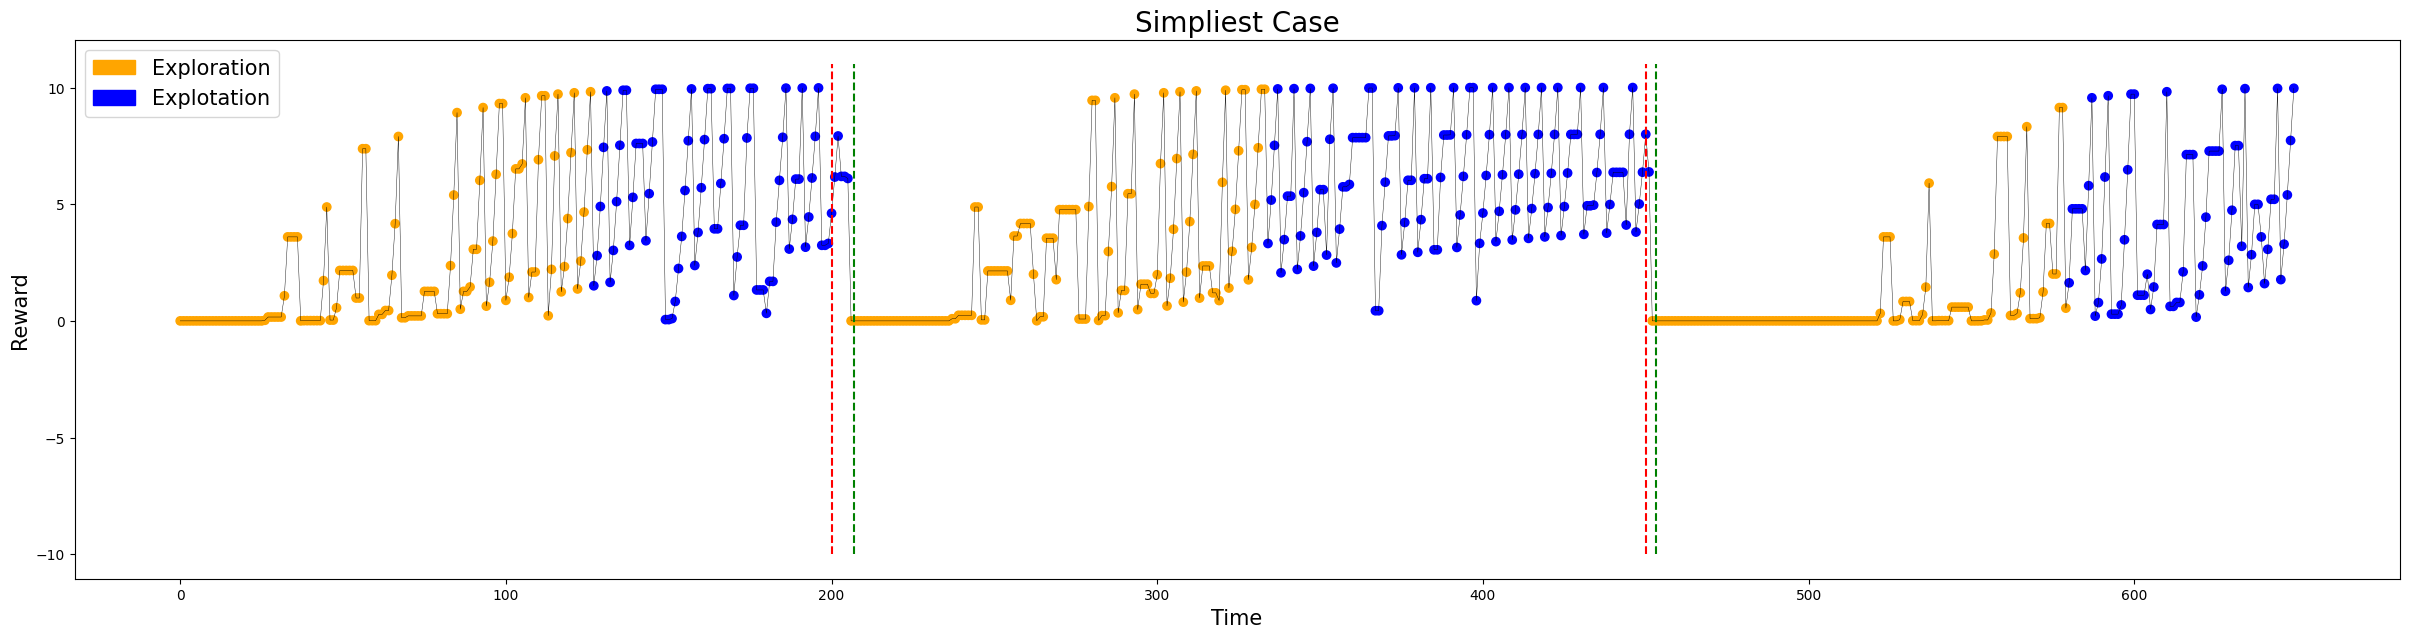

In [4]:
turti = AdaptativeAgent(initial_state=(3,2), 
                        decay_rate=0.01,
                        world_knowledge=GRID_WORLD.copy()
                        )

time = [t for t in range(650)]
moves = []
rewards = []

changing_times = [200, 450, #300, 450
                  ]
for t in time:
    
    if t in changing_times:
        turti.change_world_knowledge(TARGET_POS1, (-10)*(-1)**changing_times.index(t))
        turti.change_world_knowledge(TARGET_POS2, (10)*(-1)**changing_times.index(t))
    
    pos_i = turti.current_state
    turti.move()
    pos_f = turti.current_state
    
    action = 'Explotation' if turti.epsilon_decay(turti.step)<0.3 else 'Exploration'
    
    try:
        reward_obtained = turti.current_reward
    except KeyError:
        reward_obtained = 0
    
    moves.append(action)
    rewards.append(reward_obtained)
    
    
plt.figure(figsize=(30,7))
plt.scatter(time, rewards, color = ['blue' if m=='Explotation' else 'orange' for m in moves])
plt.plot(time, rewards, linewidth=0.3, color='k')

for tc in changing_times:
    plt.vlines(x=tc, ymin=-10, ymax=11, color='r', linestyle='--')

for line in turti.adapt_flag:
    plt.vlines(x=line, ymin=-10, ymax=11, color='g', linestyle='--')
# Crear parches para la leyenda
blue_patch = mpatches.Patch(color='blue', label='Explotation',)
orange_patch = mpatches.Patch(color='orange', label='Exploration')

# Mostrar la leyenda
plt.legend(handles=[orange_patch, blue_patch], loc='upper left', fontsize=15)
plt.ylabel('Reward', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.title('Simpliest Case', fontsize=20)
plt.show();

[9.64815627911168, 9.718525023289343, 9.774820018631475, 9.81985601490518, 9.855884811924145, 9.907766279631453, 9.926213023705163, 9.940970418964131, 9.952776335171304, 5.962221068137043] 0.1548728564801701 205
[7.657188290678353, 7.720914929264224, 7.772863380788613, 7.849061833527928, 7.876773586743772, 7.899438165332161, 7.93278821196207, 7.945216449089473, 7.955653929585726, 6.170870824187236] 0.10726924967732107 458


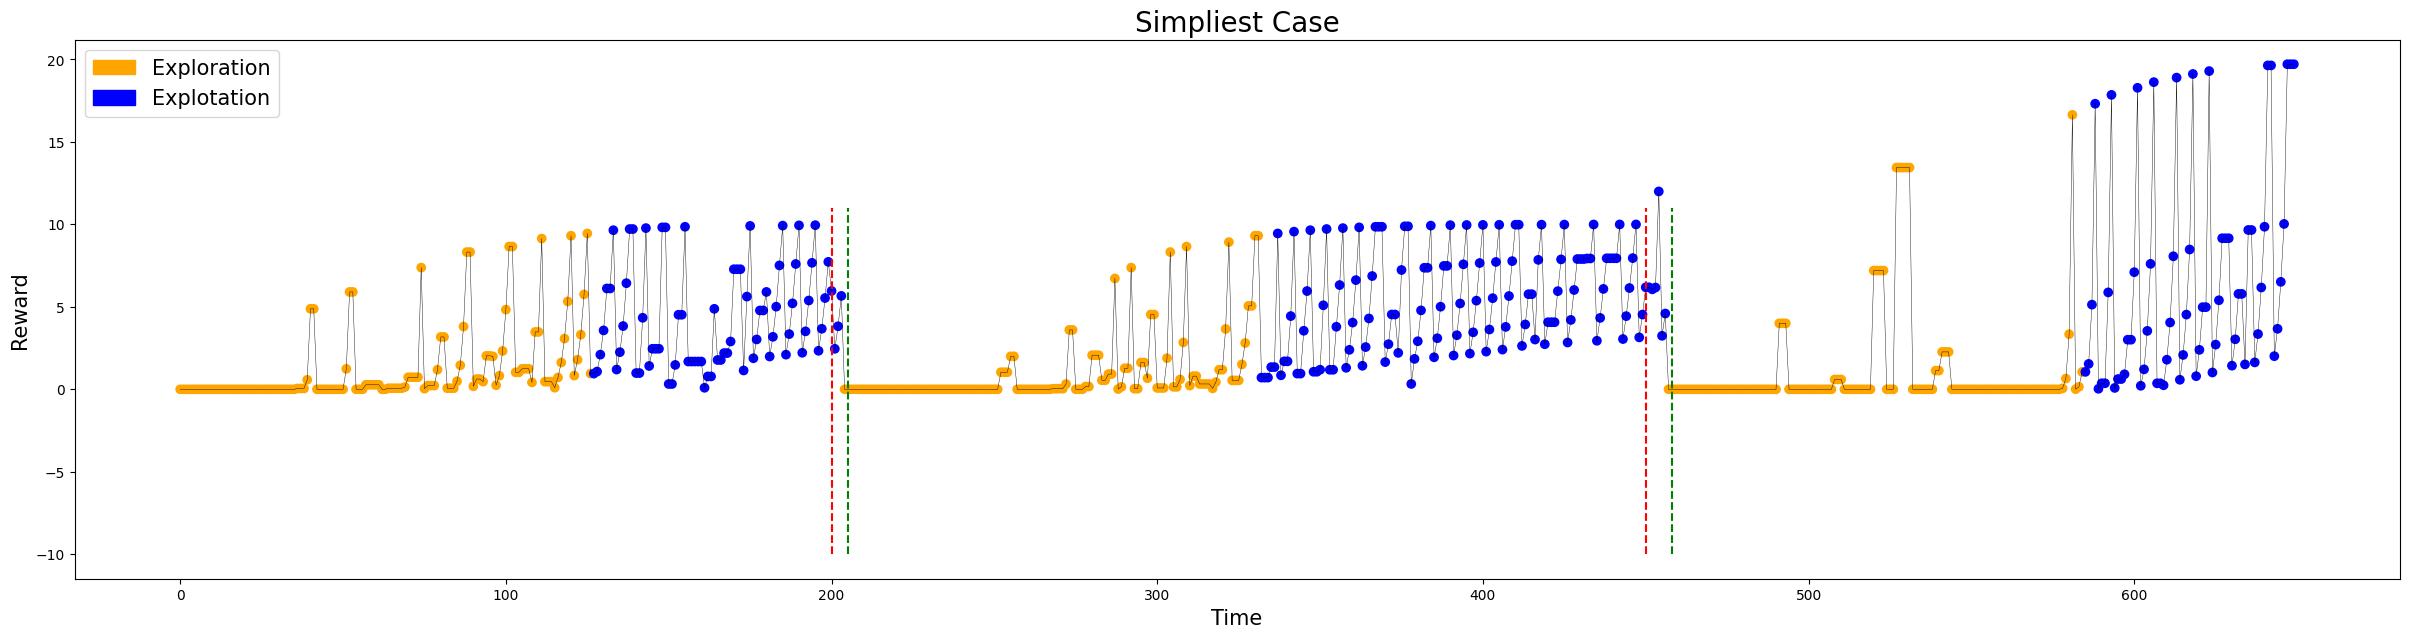

In [9]:
turti = AdaptativeAgent(initial_state=(3,2), 
                        decay_rate=0.01,
                        world_knowledge=GRID_WORLD.copy()
                        )

time = [t for t in range(650)]
moves = []
rewards = []

changing_times = [200, 450, 
                  ]
for t in time:
    
    
    if t==200:
        turti.change_world_knowledge(TARGET_POS1, (-10)*(-1)**changing_times.index(t))
        turti.change_world_knowledge(TARGET_POS2, (10)*(-1)**changing_times.index(t))
    if t==450:
        turti.change_world_knowledge((0,1), -5)
        turti.change_world_knowledge((1,1), -5)
        turti.change_world_knowledge((1,0), -5)
        turti.change_world_knowledge((0,0), 20)
    
    pos_i = turti.current_state
    turti.move()
    pos_f = turti.current_state
    
    action = 'Explotation' if turti.epsilon_decay(turti.step)<0.3 else 'Exploration'
    
    try:
        reward_obtained = turti.current_reward
    except KeyError:
        reward_obtained = 0
    
    moves.append(action)
    rewards.append(reward_obtained)
    
    
plt.figure(figsize=(30,7))
plt.scatter(time, rewards, color = ['blue' if m=='Explotation' else 'orange' for m in moves])
plt.plot(time, rewards, linewidth=0.3, color='k')

for tc in changing_times:
    plt.vlines(x=tc, ymin=-10, ymax=11, color='r', linestyle='--')

for line in turti.adapt_flag:
    plt.vlines(x=line, ymin=-10, ymax=11, color='g', linestyle='--')
# Crear parches para la leyenda
blue_patch = mpatches.Patch(color='blue', label='Explotation',)
orange_patch = mpatches.Patch(color='orange', label='Exploration')

# Mostrar la leyenda
plt.legend(handles=[orange_patch, blue_patch], loc='upper left', fontsize=15)
plt.ylabel('Reward', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.title('Simpliest Case', fontsize=20)
plt.show();

## Animation

FileNotFoundError: [Errno 2] No such file or directory: 'simulations'

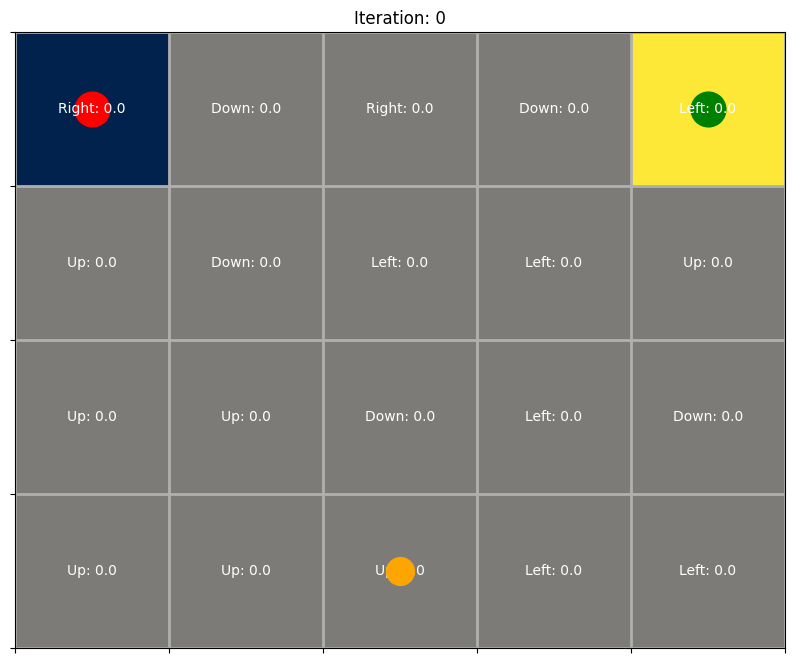

In [6]:
#turti = Agent(initial_state=(0,2), world_knowledge=GRID_WORLD.copy())
turti = AdaptativeAgent(initial_state=(3,2), 
                        decay_rate=0.01,
                        world_knowledge=GRID_WORLD.copy()
                        )

fig, ax = plt.subplots(figsize=(15, 8))


ct_1 = 180
ct_2 = 400
ct_4 = 550

def update(ite):
        
    if ite == ct_1:
        turti.change_world_knowledge(TARGET_POS1, (-10)*(-1)**changing_times.index(ite))
        turti.change_world_knowledge(TARGET_POS2, (10)*(-1)**changing_times.index(ite))
    elif ite == ct_2:
        turti.change_world_knowledge((0,1), -7)
        turti.change_world_knowledge((1,1), -7)
        turti.change_world_knowledge((1,0), -7)
        turti.change_world_knowledge((0,0), 20)
        
        
    world_knowledge = GRID_WORLD.copy()
    ax.clear()
    ax.set_title(f'Iteration: {ite}')
    ax.imshow(world_knowledge, cmap='cividis')
    
    ax.set_xticks(np.arange(-.5, N_COLS, 1))
    ax.set_yticks(np.arange(-.5, N_ROWS, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.grid(which='both', linewidth=2)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    
    for i in range(world_knowledge.shape[0]):
        for j in range(world_knowledge.shape[1]):
            best_action, value = turti.get_best_action((i,j))
            ax.text(j, i, f'{best_action}: {round(value, 3)}', ha='center', va='center', color='white')        
    
    
    stage = 'blue' if turti.epsilon_decay(turti.step)<0.3 else 'orange'
    ax.plot(turti.current_state[1], turti.current_state[0], marker='o', markersize=20, color=stage, zorder=10000)
    
    symbol1 = 'go' if turti.world_knowledge[TARGET_POS1] > 0 else 'ro'
    symbol2 = 'go' if turti.world_knowledge[TARGET_POS2] > 0 else 'ro'
    
    ax.plot(TARGET_POS1[1], TARGET_POS1[0], symbol1, markersize=25)
    ax.plot(TARGET_POS2[1], TARGET_POS2[0], symbol2, markersize=25)
    
    if ite>ct_2:
        ax.plot(1, 0, 'ro', markersize=25)
        ax.plot(1, 1, 'ro', markersize=25)
        ax.plot(0, 1, 'ro', markersize=25)
    
    
    if ite>0:
        turti.move()
    return ax

ani = animation.FuncAnimation(fig, update, frames=range(650))
ani.save('simulations/q_learning_clv2_4.gif', fps=10)